## **Calibrating a Camera**

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

corners are not found in calibration1.jpg
corners are not found in calibration4.jpg
corners are not found in calibration5.jpg


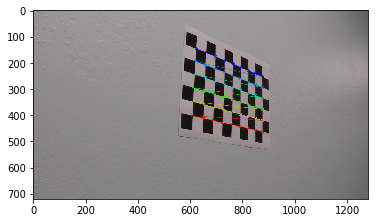

In [2]:
import glob

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
#print(images)

# Arrays to store object points and image points from all the images

objpoints = [] # 3D points in read-world space
imgpoints = [] # 2D points in image plane

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(7,5,0)
objp = np.zeros((6*9,3), np.float32)
#print(np.mgrid[0:9,0:6])
#print(np.mgrid[0:9,0:6].T)
#print(np.mgrid[0:9,0:6].T.reshape(-1,2))
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates
#print(objp)

for fname in images:
    filename = fname.split("\\")[-1]
    # read in each image
    img = cv2.imread(fname)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        
        outputpath = 'output_images/' + filename
        #print(outputpath)
        cv2.imwrite(outputpath,img)
    else:
        print('corners are not found in ' + filename)
        
#print(imgpoints)
#print(objpoints)

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [4]:
# Define x, y, magnitude, direction gradient thresholding functions

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 3) Calculate the magnitude
    abs_sobel = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    dir_sobel = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(dir_sobel)
    # 6) Return this mask as your binary_output image
    binary_output[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])] = 1
    return binary_output

In [5]:
# Define different color thresholding functions

def HLS_Sthresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary_S = np.zeros_like(S)
    binary_S[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_S

def HLS_Hthresh(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    binary_H = np.zeros_like(H)
    binary_H[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary_H

def HLS_Lthresh(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    binary_L = np.zeros_like(L)
    binary_L[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_L

def LAB_Bthresh(img, thresh=(0, 255)):
    lab = cv2.cvtColor(img,cv2.COLOR_RGB2LAB)
    B = lab[:,:,2]
    binary_B = np.zeros_like(B)
    binary_B[(B > thresh[0])&(B <= thresh[1])] = 1
    return binary_B

In [6]:
def combined_thresh(undistorted):
    binary_H = HLS_Hthresh(undistorted, thresh=(10,100))
    binary_S = HLS_Sthresh(undistorted, thresh=(170,255))
    binary_L = HLS_Lthresh(undistorted, thresh=(220,255))
    binary_B = LAB_Bthresh(undistorted, thresh=(155,255))
    gradx = abs_sobel_thresh(undistorted, orient='x', sobel_kernel=3, thresh=(15, 100))
    combined_binary = np.zeros_like(binary_L)
    #combined_binary[((binary_H == 1) & (binary_S == 1)) | (gradx == 1)] = 1
    combined_binary[(binary_L == 1) | (binary_B == 1)] = 1
    
    return combined_binary

In [7]:
# Apply a perspective transform to rectify binary image ("birds-eye view")

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    
    # Four source points, top left (tl), top right (tr), bottom left (bl), bottom right (br)

    # top left point
    srctlx = 576.651
    srctly = 462.127

    # bottom left point
    srcblx = 235.583
    srcbly = 700.472

    # bottom right point
    srcbrx = 1066.41
    srcbry = 700.42

    # top right point
    srctrx = 707.714
    srctry = 462.127

    src = np.float32(
        [[srctlx, srctly],
        [srcblx, srcbly],
        [srcbrx, srcbry],
        [srctrx, srctry]])

    # Four destination points, top left (tl), top right (tr), bottom left (bl), bottom right (br)

    # top left point
    dsttlx = img_size[0] / 4 - 70
    dsttly = 0

    # bottom left point
    dstblx = img_size[0] / 4 - 70
    dstbly = img_size[1]

    # bottom right point
    dstbrx = img_size[0] * 3 / 4 + 70
    dstbry = img_size[1]

    # top right point
    dsttrx = img_size[0] * 3 / 4 + 70
    dsttry = 0

    dst = np.float32(
        [[dsttlx, dsttly],
        [dstblx, dstbly],
        [dstbrx, dstbry],
        [dsttrx, dsttry]])
    #print(src)
    #print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return Minv, warped

In [8]:
# Finding the lanes using warped binary image

def lane_finding(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
           rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Calculate curve radius in pixel
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad_m = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad_m = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate vehicle position with respect to center of the lane

    # Calculate the offset in pixels first
    leftlane_x = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
    rightlane_x = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

    centeroflane_x = (leftlane_x + rightlane_x)*0.5
    offset = binary_warped.shape[1]*0.5 - centeroflane_x
    
    # Calculate to real offset in meters
    offset_m = offset * xm_per_pix

    return left_fit, right_fit, out_img, left_curverad_m, right_curverad_m, offset_m

In [9]:
# Project image results backdown onto the road
def lane_drawing(binary_warped, img, left_fit, right_fit, Minv, curverad_m, offset_m):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)

    # Display curve radius and vehicle position on final image

    # Take average curve radius of left and right
    lane_curve_radius = curverad_m

    font = cv2.FONT_HERSHEY_COMPLEX
    text = 'Curve Radius: ' + '{:04.2f}'.format(lane_curve_radius) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

    direction = ''
    if offset_m > 0:
        direction = 'right'
    else:
        direction = 'left'
    abs_offset_m = abs(offset_m)
    text = 'Vehicle is ' + '{:04.3f}'.format(abs_offset_m) + 'm ' + direction + ' from lane center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    
    return result

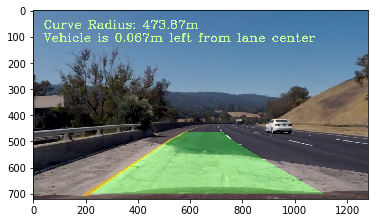

In [10]:
def img_processing(img):
    
    # Undistort the image with calibrated camera parameters
    undistorted = cal_undistort(img, objpoints, imgpoints)
    
    # Apply combined color and gradient thresholding on undistorted image
    combined_binary = combined_thresh(undistorted)
    
    # Warp the thresholded binary image
    Minv, warped = warp(combined_binary)
    
    # Find the lane line using sliding curve fitting window, alculate left/right lane curve radius and vehicle position
    left_fit, right_fit, out_img, left_curverad, right_curverad, offset_m = lane_finding(warped)
    
    # Calculate average curve radius
    curverad_m = 0.5*(left_curverad + right_curverad)
    
    # lane drawing with above lane finding results
    final_image = lane_drawing(warped, undistorted, left_fit, right_fit, Minv, curverad_m, offset_m)
    
    return final_image

# Test final image processing function with other images
img = cv2.imread('test_images/fram42.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
adv_lane_finding = img_processing(img)
plt.imshow(adv_lane_finding)

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
output = 'project_video_output.mp4'

## Use the following line for a shorter subclip, use next line for entire video
## clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,4)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(img_processing) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [19:07<00:00,  1.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 19min 9s


In [24]:
# Cutting a portion of the video which has a problem for finding lanes
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip("project_video.mp4", 6, 9, targetname="project_video_difficult.mp4")


[MoviePy] Running:
>>> ffmpeg -y -i project_video.mp4 -ss 6.00 -t 3.00 -vcodec copy -acodec copy project_video_difficult.mp4
... command successful.


In [26]:
import os
# Splitting Video Images with OpenCV and Python
cap = cv2.VideoCapture('project_video_difficult.mp4')

try:
    if not os.path.exists('data'):
        os.makedirs('data')
except OSError:
    print ('Error: Creating directory of data')
    
currentFrame = 0
success = True
while(success):
    # Capture frame-by-frame
    success, frame = cap.read()
    
    # Save image of the current frame in jpg file
    name = './data/frame' + str(currentFrame) + '.jpg'
    print('Creating...' + name)
    cv2.imwrite(name, frame)
    
    # To stop duplicate images
    currentFrame +=1
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

Creating..../data/frame0.jpg
Creating..../data/frame1.jpg
Creating..../data/frame2.jpg
Creating..../data/frame3.jpg
Creating..../data/frame4.jpg
Creating..../data/frame5.jpg
Creating..../data/frame6.jpg
Creating..../data/frame7.jpg
Creating..../data/frame8.jpg
Creating..../data/frame9.jpg
Creating..../data/frame10.jpg
Creating..../data/frame11.jpg
Creating..../data/frame12.jpg
Creating..../data/frame13.jpg
Creating..../data/frame14.jpg
Creating..../data/frame15.jpg
Creating..../data/frame16.jpg
Creating..../data/frame17.jpg
Creating..../data/frame18.jpg
Creating..../data/frame19.jpg
Creating..../data/frame20.jpg
Creating..../data/frame21.jpg
Creating..../data/frame22.jpg
Creating..../data/frame23.jpg
Creating..../data/frame24.jpg
Creating..../data/frame25.jpg
Creating..../data/frame26.jpg
Creating..../data/frame27.jpg
Creating..../data/frame28.jpg
Creating..../data/frame29.jpg
Creating..../data/frame30.jpg
Creating..../data/frame31.jpg
Creating..../data/frame32.jpg
Creating..../data/fr